In [1]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils

In [2]:
data_dir = '/Users/rebekahzhang/data/neural_data'
pickle_dir = Path(os.path.join(data_dir, 'session_pickles'))

# filter sessions based on performance

In [3]:
sessions_all_raw = pd.read_csv(os.path.join(data_dir, 'sessions_all_raw.csv'), index_col=0).sort_values('id')

In [4]:
def get_session_length(trials):
    session_start_time = trials['event_start_time'].iloc[0]
    session_end_time = trials['event_end_time'].iloc[-1]
    session_length = session_end_time - session_start_time
    return session_length

def add_session_performance(sessions_all_raw, pickle_dir):
    session_performance_list = []
    for _, session_info in sessions_all_raw.iterrows():
        session_id = session_info['id']
        filename = session_id + ".pkl"
        _, trials, _ = utils.get_session_data(filename, pickle_dir)

        sesson_performance_dict = {
            'id': session_id,
            'length': get_session_length(trials),
            'num_trials': len(trials),
            'num_missed': trials.missed.sum(),
            'wait_length_mean': trials.wait_length.mean()

        }
        session_performance_list.append(sesson_performance_dict)
    session_performance = pd.DataFrame(session_performance_list)
    session_performance_log = pd.merge(sessions_all_raw, session_performance)
    return session_performance_log
    

In [5]:
sessions_all = add_session_performance(sessions_all_raw, pickle_dir)
sessions_all.to_csv(os.path.join(data_dir, 'sessions_all.csv'))

Text(0.5, 1.0, 'Session Length Distribution')

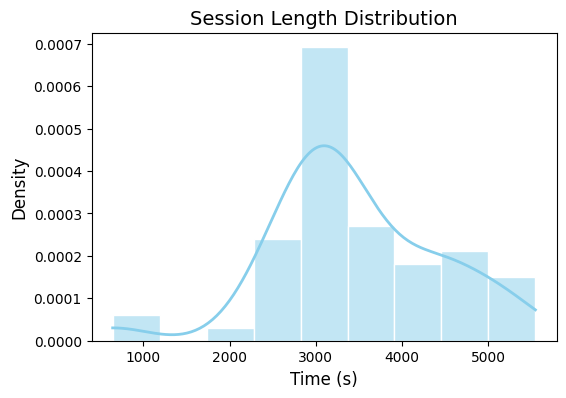

In [6]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=sessions_all['length'],
    kde=True,          # Adds KDE trend line
    stat="density",    # Normalizes histogram to match KDE scale
    bins="auto",       # Auto-selects bin size (or set manually, e.g., bins=30)
    color="skyblue",   # Histogram color
    edgecolor="white", # Edge color for bars
    line_kws={"color": "red", "lw": 2}  # KDE line style
)

# Labels & title
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Session Length Distribution', fontsize=14)

In [7]:
sessions_vetted = sessions_all.loc[
    (sessions_all['num_units'] >= 1) &  # Not quiet
    (sessions_all['length'] >= 1500)    # Not short
]

In [8]:
sessions_vetted.to_csv(os.path.join(data_dir, 'sessions_vetted.csv'))

# generate units log

In [9]:
sessions_vetted = pd.read_csv(os.path.join(data_dir, 'sessions_vetted.csv'), index_col=0).sort_values('id')

In [10]:
def generate_units_all(sessions_vetted, pickle_dir):
    unit_info_list = []
    sessions_with_units = sessions_vetted.loc[sessions_all.num_units>0]
    for _, session_info in sessions_with_units.iterrows():
        session_id = session_info['id']
        filename = session_id + ".pkl"
        _, _, units = utils.get_session_data(filename, pickle_dir)
        for i, spikes in enumerate(units):
            unit_id = f"{session_id}-unit_{i}"
            spiked_trials = spikes.trial_id.nunique()
            percent_trials_w_spikes = spiked_trials/session_info['num_trials']
            session_fr = len(spikes)/session_info['length']
            unit_info_dict = {
                'session_id': session_id,
                'id': i,
                'unit_id': unit_id,
                'region': session_info['region'],
                'percent_trials_w_spikes': percent_trials_w_spikes,
                'session_fr': session_fr
            }
            unit_info_list.append(unit_info_dict)
    units_all = pd.DataFrame(unit_info_list)
    return units_all

In [11]:
units_all = generate_units_all(sessions_vetted, pickle_dir)
units_all.to_csv(os.path.join(data_dir, 'units_all.csv'))
print(f"{len(units_all)} units")

1346 units


Text(0.5, 1.0, 'Session Length Distribution')

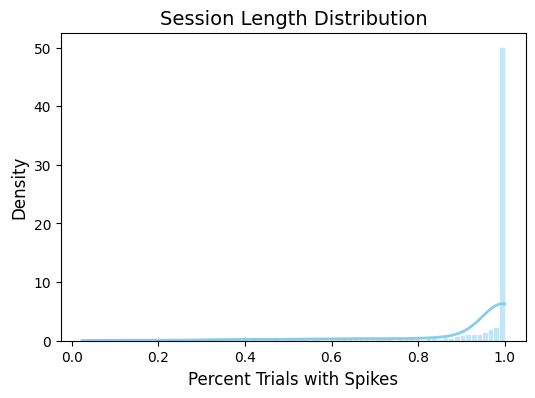

In [12]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=units_all['percent_trials_w_spikes'],
    kde=True,          # Adds KDE trend line
    stat="density",    # Normalizes histogram to match KDE scale
    bins="auto",       # Auto-selects bin size (or set manually, e.g., bins=30)
    color="skyblue",   # Histogram color
    edgecolor="white", # Edge color for bars
    line_kws={"color": "red", "lw": 2}  # KDE line style
)

# Labels & title
plt.xlabel('Percent Trials with Spikes', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Session Length Distribution', fontsize=14)

Text(0.5, 1.0, 'Session Length Distribution')

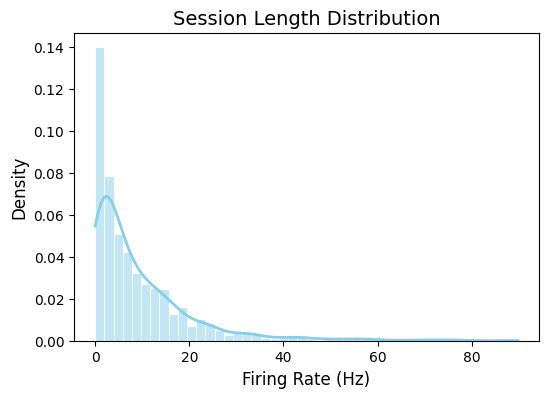

In [13]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=units_all['session_fr'],
    kde=True,          # Adds KDE trend line
    stat="density",    # Normalizes histogram to match KDE scale
    bins="auto",       # Auto-selects bin size (or set manually, e.g., bins=30)
    color="skyblue",   # Histogram color
    edgecolor="white", # Edge color for bars
    line_kws={"color": "red", "lw": 2}  # KDE line style
)

# Labels & title
plt.xlabel('Firing Rate (Hz)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Session Length Distribution', fontsize=14)

In [15]:
units_vetted = units_all.loc[units_all['percent_trials_w_spikes'] >= 0.8]
units_vetted.to_csv(os.path.join(data_dir, 'units_vetted.csv'))

print(f"{len(units_vetted)} units")

1119 units
